In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import statsmodels.api as sm
import warnings
import itertools
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

Set up data for later

In [3]:
df=pd.read_csv('./resources/Sales_Data.csv', sep='\t', index_col=0)
df['purchase_date']= pd.to_datetime(df['purchase_date']) 
df = df[df['payment_amount']>100]
daily_sales = df.groupby(['purchase_date'])['payment_amount'].sum()
monthly_sales = daily_sales.resample('m').sum()
monthly_sales = pd.DataFrame(monthly_sales, columns=['payment_amount'])


# Time Series Analysis: SARIMA Model


**Goal:** Students will be able to build and evaluate an ARIMA based model using ACF and PACF plots to choose the appropriate terms of the model.

**Agenda:**  
- Explain AR and MA terms
- Explain ACF and PACF charts
- Build an SARIMA Model

### Great Resources:

- https://newonlinecourses.science.psu.edu/stat510/lesson/1
- https://people.duke.edu/~rnau/411arim.htm

## Types of Models
There are two basic types of “time domain” models:

- Models that relate the present value of a series to past values and past prediction errors - these are called **ARIMA** models (for Autoregressive Integrated Moving Average). We’ll spend substantial time on these.
- Ordinary regression models that use time indices as x-variables. These can be helpful for an initial description of the data and form the basis of several simple forecasting methods.

### Running a linear regression model with stationary time series data

You can take your newly stationary data and use it as your target variable for a linear regression model. 

Making your data stationary tries to remove the correlation between serial time points. There still can be soem element of time that can explain changes in your target variable. A leap year, for example, will add an extra day for sales in February.  

1. How should we account for this in our linear regression model?
2. What are other time components that we might want to account for in a linear regression model? (think about other examples of hourly, daily, or weekly data)

***When performing a linear regression model on time series data, you need to eventually transformyour data back to the original scale***

### Reversing a first difference

In [4]:
#create a dataframe with random numbers
df_diff = pd.DataFrame({'A': np.random.randint(0, 10, 10)})
#create the first difference column
df_diff['B'] = df_diff['A'].diff()

#Reverse the first difference
x, x_diff = df_diff['A'].iloc[0], df_diff['B'].iloc[1:]
df_diff['C'] = np.r_[x, x_diff].cumsum().astype(int)

#view the data
df_diff

,A,B,C
0,7,NaN,7
1,7,0.0,7
2,9,2.0,9
3,8,-1.0,8
4,4,-4.0,4
5,2,-2.0,2
6,2,0.0,2
7,7,5.0,7
8,6,-1.0,6
9,2,-4.0,2


### Steps to creating an Arima model for time series data
![steps](./resources/flowchart.png)

## Plot ACF/PACF charts and find optimal parameters.

One we have achieved stationarity the next step in fitting a model to address any autocorrelation that remains in the differenced series.

### Autocorrelation Function ACF


The sample autocorrelation function (ACF) for a series gives correlations between the series and lagged values of the series for lags of 1, 2, 3, and so on. The lagged values can be written as $Y_{t-1}$, $Y_{t-2}$, $Y_{t-3}$ and so on. The ACF gives correlations between $Y_t$ and $Y_{t-1}$, $Y_t$ and $Y_{t-2}$, and so on.

The ACF can be used to identify the possible structure of time series data. That can be tricky going forward as there often isn’t a single clear-cut interpretation of a sample autocorrelation function.

<Figure size 864x576 with 0 Axes>

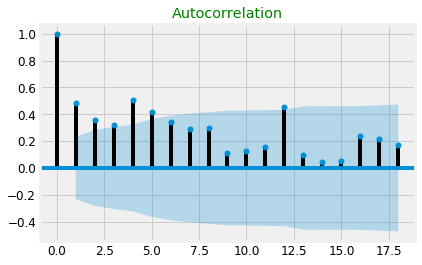

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_sales.payment_amount.iloc[1:], lags=18, ax=ax1)


### Partial autocorrelation 

In general, a partial correlation is a conditional correlation. It is the  amount of correlation between a variable and a lag of itself that is not explained by correlations at all lower-order-lags. The autocorrelation of a time series $Y$ at lag 1 is the coefficient of correlation between $Y_t$ and $Y_{t-1}$, which is presumably also the correlation between $Y_{t-1}$ and $Y_{t-2}$. But if $Y_t$ is correlated with $Y_{t-1}$, and $Y_{t-1}$ is equally correlated with $Y_{t-2}$, then we should also expect to find correlation between $Y_t$ and $Y_{t-2}$. In fact, the amount of correlation we should expect at lag 2 is precisely the square of the lag-1 correlation. Thus, the correlation at lag 1 "propagates" to lag 2 and presumably to higher-order lags. The partial autocorrelation at lag 2 is therefore the difference between the actual correlation at lag 2 and the expected correlation due to the propagation of correlation at lag 1.


<Figure size 864x576 with 0 Axes>

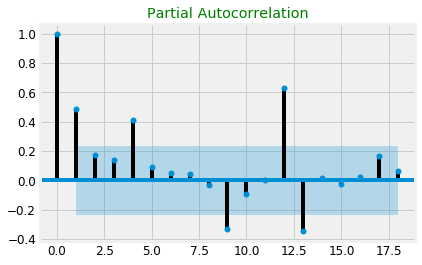

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_sales.payment_amount.iloc[1:], lags=18, ax=ax1)

Why is this important? 

#### Determinging AR and MA terms

If after making your data stationary, there is still come autocorrelation between time periods, we can use that relationship to help predict future time periods.  



### Autoregressive Integrated Moving Average  (ARIMA)

#### Autoregressive term

If the series is stationary and autocorrelated, perhaps it can be predicted as a multiple of its own previous value, plus a constant.  The forecasting equation in this case is:


$$Ŷ_t  =  μ  +  ϕ_{t-1}Y_{t-1}$$

…which is Y regressed on itself lagged by one period. 

### Integrated

Refers to the order of differencing used in the model. 

####  Moving Average term

Another strategy for correcting autocorrelated errors is to use an average of the last few observations in order to filter out the noise and more accurately estimate the local mean. One of which is the so-called “error correction” form, in which the previous forecast is adjusted in the direction of the error it made:

$$Ŷ_t   =  Ŷ_{t-1}  + αe_{t-1}$$  

Because $e_{t-1} = Y_{t-1} - Ŷ_{t-1}$ by definition, this can be rewritten as:

$$Ŷ_t   =  Y_{t-1}  - (1-α)e_{t-1}$$

$$Ŷ_t=  Y_{t-1}  - θ_1e_{t-1}$$




An ARIMA model is classified as an **ARIMA(p,d,q)** model, 

    **p** = number of autoregressive (AR) terms 
    **d** = number of differences 
    **q** = number of moving average (MA) terms

# Seasonal ARIMA model with Exogenous Factors  (SARIMAX)

A seasonal ARIMA model is classified as an **ARIMA(p,d,q)x(P,D,Q)** model, 

    **p** = number of autoregressive (AR) terms 
    **d** = number of differences 
    **q** = number of moving average (MA) terms
     
    **P** = number of seasonal autoregressive (SAR) terms 
    **D** = number of seasonal differences 
    **Q** = number of seasonal moving average (SMA) terms
    
**Exogenous Factors** refers to any features that are not derived from the target variable.  

A rule-of-thumb for this situation, which will be discussed in more detail later on, is that positive autocorrelation is usually best treated by adding an AR term to the model and negative autocorrelation is usually best treated by adding an MA term. 


![alt text](./resources/armaguidelines.png)

#### Rules for Indentifying ARIMA Models

https://people.duke.edu/~rnau/arimrule.htm

One way is just to run all combinations of options and see which one performs the best by some metric:

In [5]:
p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))


Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 1, 0, 12)
SARIMAX: (0, 1, 0) x (1, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (1, 1, 0, 12)
SARIMAX: (0, 1, 1) x (1, 1, 1, 12)
SARIMAX: (1, 1, 0) x (0, 1, 0, 12)
SARIMAX: (1, 1, 0) x (0, 1, 1, 12)
SARIMAX: (1, 1, 0) x (1, 1, 0, 12)
SARIMAX: (1, 1, 0) x (1, 1, 1, 12)
SARIMAX: (1, 1, 1) x (0, 1, 0, 12)
SARIMAX: (1, 1, 1) x (0, 1, 1, 12)
SARIMAX: (1, 1, 1) x (1, 1, 0, 12)
SARIMAX: (1, 1, 1) x (1, 1, 1, 12)


In [6]:
y = monthly_sales['payment_amount']

In [7]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1524.4534149930785
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1210.602051166244
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:1238.0369790205784
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1212.0593494767272
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1489.7467971795493
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1164.440453947393
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:1213.808670482702
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1164.029625530262
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1518.917752828626
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1201.8220256084944
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:1201.873343840109
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1203.7958741080258
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:1489.589500764431
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1166.2946974309355
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:1189.9811095649065
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1165.7510089875316


## ACF and PACF

#### Original Data

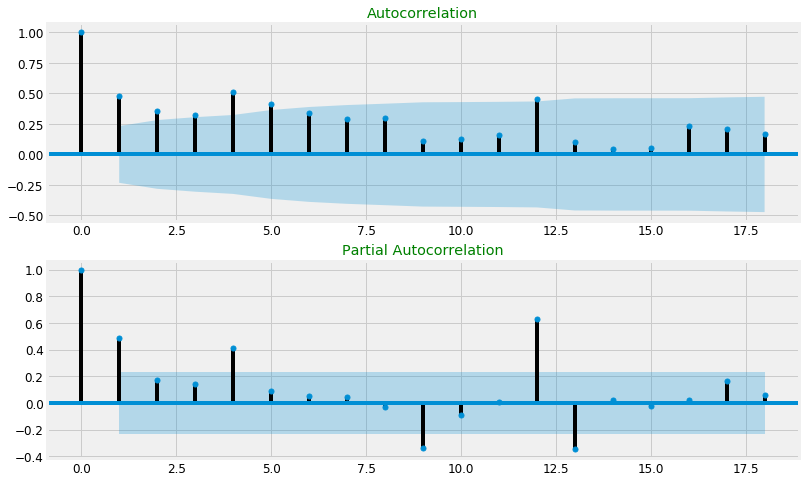

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_sales.payment_amount.iloc[1:], lags=18, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_sales.payment_amount.iloc[1:], lags=18, ax=ax2)

When Looking at the ACF graph for the original data, we see a strong persistent correlation with higher order lags. This is evidence that we should take a first diefference of the data to remove this autocorrelation.

In [19]:
monthly_sales['first_difference'] = monthly_sales.payment_amount - monthly_sales.payment_amount.shift(1)  

#### First Difference

Now that we have taken a first difference, lets analyze the ACF and PACF plots again to see if there is more autocorrelation we need to account for.

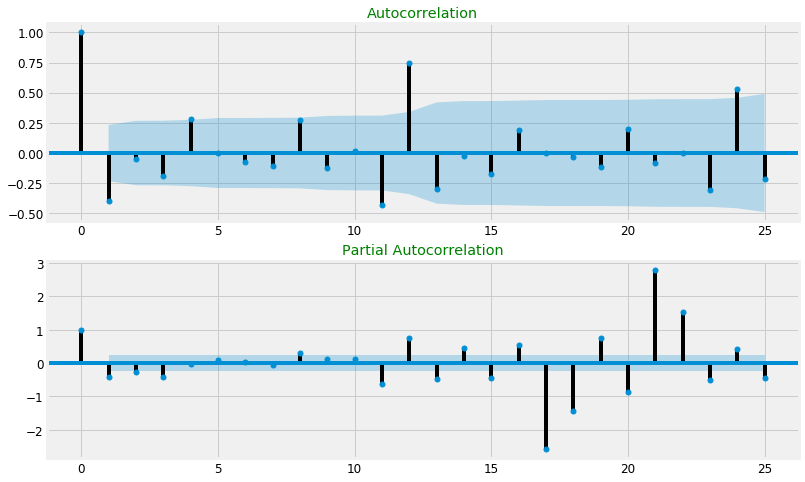

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_sales.first_difference.iloc[1:], lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_sales.first_difference.iloc[1:], lags=25, ax=ax2)

Here we see ha huge autocorrelation and partial autocorrelation at lag 12 and 24. This is due to the seasonality of the data.  Therefore we should take a seasonal difference as well. 

In [ ]:
monthly_sales['seasonal_first_difference'] = monthly_sales.first_difference - monthly_sales.first_difference.shift(12)  


#### Seasonal first difference

Now that we have taken both a seasonal and first diefference, let's revaluate our ACF and PACF plots to check for autocorrelation.

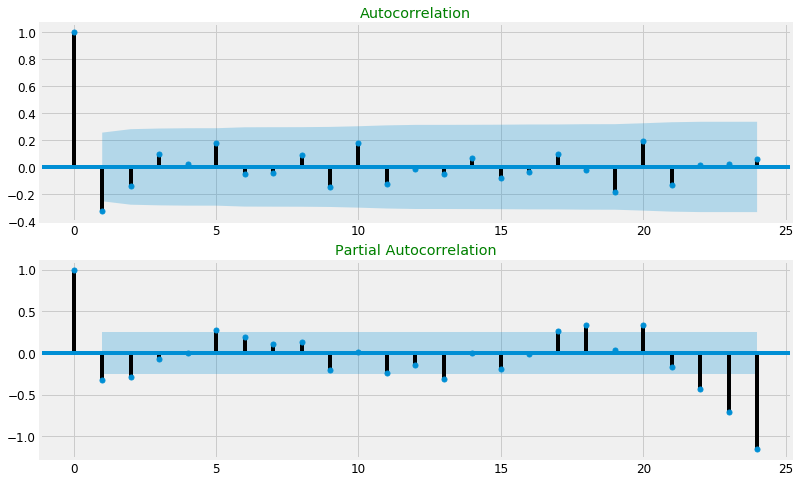

In [20]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(monthly_sales.seasonal_first_difference.iloc[13:], lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(monthly_sales.seasonal_first_difference.iloc[13:], lags=24, ax=ax2)

Looking at these graphs, I see a significatn negative correlation at lags 1 and 13. This leads me to believe we should include one MA term and one SMA term in our model.

### Question

If you are trying to predict sales of grad school prep courses, what are some exogenous features you would want to include in your model?

### Estimating and Diagnosing a Possible Model
After you’ve made a guess (or two) at a possible model, use software such as R, Minitab, or SAS to estimate the coefficients. Most software will use maximum likelihood estimation methods to make the estimates. Once the model has been estimated, do the following.

- Look at the significance of the coefficients. In R, sarima provides p-values and so you may simply compare the p-value to the standard 0.05 cut-off. The arima command does not provide p-values and so you can calculate a t-statistic:  = estimated coeff. / std. error of coeff. Recall that  is the Student -value with area  to the right of  on df degrees of freedom. If , then the estimated coefficient is significantly different from 0. When n is large, you may compare estimated coeff. / std. error of coeff to 1.96.
- Look at the ACF of the residuals. For a good model, all autocorrelations for the residual series should be non-significant. If this isn’t the case, you need to try a different model.
- Look at Box-Pierce (Ljung) tests for possible residual autocorrelation at various lags (see Lesson 3.2 for a description of this test).
- If non-constant variance is a concern, look at a plot of residuals versus fits and/or a time series plot of the residuals.
If something looks wrong, you’ll have to revise your guess at what the model might be. This might involve adding parameters or re-interpreting the original ACF and PACF to possibly move in a different direction.

### What if More Than One Model Looks Okay?
Sometimes more than one model can seem to work for the same dataset. When that’s the case, some things you can do to decide between the models are:

- Possibly choose the model with the fewest parameters.
- Examine standard errors of forecast values. Pick the model with the generally lowest standard errors for predictions of the future.
- Compare models with regard to statistics such as the MSE (the estimate of the variance of the wt), AIC, AICc, and SIC (also called BIC). Lower values of these statistics are desirable.

## Fitting the Model

https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [ ]:
sm.tsa.statespace.SARIMAX()

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [ ]:
monthly_sales

In [ ]:
#create predictions of  data 
#dynamic = False means that we are only predcicting one step ahead
pred = results.get_prediction(start=pd.to_datetime('2015-06-30'), dynamic=True)


In [ ]:
#this helps us to see the confidence intervals of our predictions
pred_ci = pred.conf_int()

In [ ]:
#plot our predictions against actual data
ax = monthly_sales['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

## Evaluating a Time Series Model

Can we use test train split when evaluating this model? 

<img src='https://people.duke.edu/~rnau/randwkf2.gif' width=700 />

-  The data in the **estimation period** are used to help select the model and to estimate its parameters. Forecasts made in this period are not completely "honest" because data on both sides of each observation are used to help determine the forecast. 

- The data in the **validation period** are held out during parameter estimation, and if you are careful you will also withhold these values during the exploratory phase of analysis when you select your model. One-step-ahead forecasts made in this period are often called backtests. Ideally, these are "honest" forecasts, however, if you test a great number of models and choose the model whose errors are smallest in the validation period, you may end up overfitting the data within the validation period as well as in the estimation period.

- **Forecasts into the future** are "true" forecasts that are made for time periods beyond the end of the available data. For a model which is purely extrapolative in nature , it is possible to extend the forecasts an arbitrary number of periods into the future by "bootstrapping" the model: first a one-period-ahead forecast is made, then the one-period-ahead forecast is treated as a data point and the model is cranked ahead to produce a two-period-ahead forecast, and so on as far as you wish.

In [ ]:

y_forecasted = pred.predicted_mean
y_truth = y['2015-06-30':]

#calculate the MSE for the data
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

## Now let's predict all of 2016

In order for this to work, we need to extend our current data frame to account for the future time periods we will predict on.

In [ ]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
from dateutil.relativedelta import relativedelta

start = datetime.datetime.strptime("2016-01-31", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= monthly_sales.columns)
monthly_sales = pd.concat([monthly_sales, future])

In [ ]:
res.predict()

In [ ]:
monthly_sales['forecast'] = res.predict(start = 72, end = 84, dynamic= True)  
monthly_sales[['payment_amount', 'forecast']].iloc[-24:].plot(figsize=(12, 8)) 
plt.savefig('ts_predict_future.png', bbox_inches='tight')

## Application practice with dataset of trasit riders in Portland